# Testing momentum distributions using single-particle wave functions

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ January 23, 2023

This notebook serves as a testbed for calculating momentum distributions using mean field approximations for initial and final states and applying SRG transformations to the operator. This differs from the previous momentum distribution calculations by directly utilizing single-particle wave functions instead of a local density approximation. In this version, we test several `vegas` options to speed-up the code.

_Last update:_ May 1, 2023

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
# Imports from scripts
from scripts.figures import label_lambda, label_nucleus, set_rc_parameters
from scripts.momentum_distributions import MomentumDistribution
from scripts.tools import replace_periods

## Set-up

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

In [4]:
# Save figures in the following directory
figures_directory = '../figures/momentum_distributions/'
vmc_directory = '../data/vmc/momentum_distributions/'

## Momentum distributions

In [5]:
def load_momentum_distribution(nucleus_name, nucleon, lamb):
    """Load and return the momentum distribution along with the isolated
    contributions.
    """
    
    file_name = replace_periods(
        f"{nucleus_name}_{nucleon}_momentum_distribution_{lamb}"
    )
    
    data = np.loadtxt(file_name + '.txt')
    
    q_array = data[:, 0]
    q_weights = data[:, 1]
    n_array = data[:, 2]
    n_errors = data[:, 3]
    I_array = data[:, 4]
    delta_U_array = data[:, 5]
    delta_U_errors = data[:, 6]
    delta_U2_array = data[:, 7]
    delta_U2_errors = data[:, 8]

#     data = np.loadtxt(file_name + '.txt', dtype='complex')
    
#     q_array = data[:, 0].real
#     q_weights = data[:, 1].real
#     n_array = data[:, 2].real
#     n_errors = data[:, 3].real
#     I_array = data[:, 4].real
#     delta_U_array = data[:, 5]
#     delta_U_errors = data[:, 6].real
#     delta_U2_array = data[:, 7]
#     delta_U2_errors = data[:, 8].real
    
    return (q_array, q_weights, n_array, n_errors, I_array, delta_U_array,
            delta_U_errors, delta_U2_array, delta_U2_errors)

In [6]:
def proton_momentum_distribution(
        nucleus_name, Z, N, kvnn, lamb, error_bars=False, x_limits=(0.0,10.0),
        y_limits=(9e-6,1e3), y_scale='log', print_normalization=False,
        show_vmc=False, save=False
):
    """Plots nuclear proton momentum distributions with several built-in
    options.
    """
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))

    # Normalization factor to compare to VMC data
    factor = (2*np.pi)**3
    
    if y_scale == 'log':
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
        
    # Compare to VMC calculation?
    if show_vmc:
        
        file_name = f"{nucleus_name}_single_nucleon.txt"
        data = np.loadtxt(vmc_directory + file_name)
        q_array_vmc = data[:,0]
        n_array_vmc = data[:,1]
        n_errors_vmc = data[:,2]
        
        if y_scale == 'linear':
            
            ax.errorbar(
                q_array_vmc, n_array_vmc*q_array_vmc**2, yerr=n_errors_vmc,
                color='black', label='VMC', linestyle='', marker='.'
            )
            
        else:
            
            ax.errorbar(
                q_array_vmc, n_array_vmc, yerr=n_errors_vmc, color='black',
                label='VMC', linestyle='', marker='.'
            )

    # Load data from file
    q_array, q_weights, n_array, n_errors, n_ipm_array, _, _, _, _ = (
        load_momentum_distribution(nucleus_name, 'proton', lamb)
    )

    if y_scale == 'linear':
        
        if error_bars:
            
            ax.errorbar(
                q_array, n_array*factor*q_array**2, yerr=n_errors, color='blue',
                label='SRG', linestyle='solid', linewidth=2.0
            )
    
        else:
            
            ax.plot(q_array, n_array*factor*q_array**2, label='SRG',
                    linewidth=2.0)
            
        ax.plot(q_array, n_ipm_array*factor*q_array**2, label='IPM',
                linestyle='dotted', linewidth=2.0)

    else:
        
        if error_bars:
            
            ax.errorbar(q_array, n_array*factor, yerr=n_errors, color='blue',
                        label='SRG', linestyle='solid', linewidth=2.0)
    
        else:
            
            ax.plot(q_array, n_array*factor, label='SRG', linewidth=2.0)
            
        ax.plot(q_array, n_ipm_array*factor, label='IPM', linestyle='dotted',
                linewidth=2.0)

    # Print normalization?
    if print_normalization:
        
        srg_norm = (4*np.pi)/(2*np.pi)**3 * np.sum(
            q_weights * q_array**2 * n_array*factor
        )
        print(f"SRG normalization = {srg_norm}.")
        
        ipm_norm = (4*np.pi)/(2*np.pi)**3 * np.sum(
            q_weights * q_array**2 * n_ipm_array*factor
        )
        print(f"IPM normalization = {ipm_norm}.")
        
        if show_vmc:
            
            dq = q_array_vmc[2] - q_array_vmc[1]
            vmc_norm = (
                (4*np.pi)/(2*np.pi)**3*np.sum(dq*q_array_vmc**2*n_array_vmc)
            )
            print(f"VMC normalization = {vmc_norm}.")
    
    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    ax.set_ylabel(r"$n_{p}(q)$ [fm" + r'$^3$' + ']', fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=14, frameon=False)

    # Add nucleus and \lambda label
    label = label_nucleus(nucleus_name) + ", " + label_lambda(lamb)
    ax.set_title(label, fontsize=14)
#     ax.add_artist(
#         AnchoredText(label, loc='center right', prop=dict(size=18),
#                      frameon=False)
#     )
    
    # Save?
    if save:
        file_name = replace_periods(
            f"{nucleus_name}_proton_momentum_distribution_kvnn_{kvnn}"
            f"_lamb_{lamb}_{y_scale}_scale"
        )
        f.savefig(figures_directory + file_name + '.png')

In [7]:
def momentum_distribution_contributions(
        nucleus_name, Z, N, kvnn, lamb, error_bars=False, x_limits=(0.0,10.0),
        y_limits=(9e-6,1e3), y_scale='log', print_normalization=False,
        show_vmc=False, save=False
):
    """Plots nuclear proton momentum distributions showing I,
    \delta U + \delta U^\dagger, and \delta U \delta U^\dagger contributions.
    """
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))

    # Normalization factor to compare to VMC data
    factor = (2*np.pi)**3
    
    if y_scale == 'log':
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
        
    # Compare to VMC calculation?
    if show_vmc:
        
        file_name = f"{nucleus_name}_single_nucleon.txt"
        data = np.loadtxt(vmc_directory + file_name)
        q_array_vmc = data[:,0]
        n_array_vmc = data[:,1]
        n_errors_vmc = data[:,2]
        
        if y_scale == 'linear':
            
            ax.errorbar(
                q_array_vmc, n_array_vmc*q_array_vmc**2, yerr=n_errors_vmc,
                color='black', label='VMC', linestyle='', marker='.'
            )
            
        else:
            
            ax.errorbar(
                q_array_vmc, n_array_vmc, yerr=n_errors_vmc, color='black',
                label='VMC', linestyle='', marker='.'
            )

    
    # Load data from file
    (q_array, q_weights, n_array, n_errors, n_I_array, n_delU_array,
     n_delU_errors, n_delU2_array, n_delU2_errors) = (
        load_momentum_distribution(nucleus_name, 'proton', lamb)
    )

    if y_scale == 'linear':
        
        ax.plot(q_array, n_I_array*factor*q_array**2, color='blue', label='I', 
                linestyle='dotted', linewidth=2.0, zorder=2)
        
        if error_bars:
        
            ax.errorbar(
                q_array, n_array*factor*q_array**2, yerr=n_errors,
                color='black', label='Total', linestyle='solid', linewidth=2.0,
                zorder=1
            )
            ax.errorbar(
                q_array, abs(n_delU_array)*factor*q_array**2,
                yerr=n_delU_errors, color='green',
                label=r'$|\delta U+\delta U^\dagger|$', linestyle='dashed',
                linewidth=2.0, zorder=3
            )
            ax.plot(
                q_array, abs(n_delU2_array)*factor*q_array**2,
                yerr=n_delU2_errors, color='red',
                label=r'$\delta U \delta U^\dagger$', linestyle='dashdot',
                linewidth=2.0, zorder=4
            )

        else:
            
            ax.plot(
                q_array, n_array*factor*q_array**2, color='black',
                label='Total', linewidth=2.0, zorder=1
            )
            ax.plot(
                q_array, abs(n_delU_array)*factor*q_array**2, color='green',
                label=r'$|\delta U+\delta U^\dagger|$', linestyle='dashed',
                linewidth=2.0, zorder=3
            )
            ax.plot(
                q_array, abs(n_delU2_array)*factor*q_array**2, color='red',
                label=r'$\delta U \delta U^\dagger$', linestyle='dashdot',
                linewidth=2.0, zorder=4
            )

    else:
        
        ax.plot(q_array, n_I_array*factor, color='blue', label='I', 
                linestyle='dotted', linewidth=2.0, zorder=2)
        
        if error_bars:
        
            ax.errorbar(
                q_array, n_array*factor, yerr=n_errors, color='black',
                label='Total', linestyle='solid', linewidth=2.0, zorder=1
            )
            ax.errorbar(
                q_array, abs(n_delU_array)*factor, yerr=n_delU_errors,
                color='green', label=r'$|\delta U+\delta U^\dagger|$',
                linestyle='dashed', linewidth=2.0, zorder=3
            )
            ax.plot(
                q_array, abs(n_delU2_array)*factor, yerr=n_delU2_errors,
                color='red', label=r'$\delta U \delta U^\dagger$',
                linestyle='dashdot', linewidth=2.0, zorder=4
            )

        else:
            
            ax.plot(q_array, n_array*factor, color='black', label='Total',
                    linewidth=2.0, zorder=1)
            ax.plot(
                q_array, abs(n_delU_array)*factor, color='green',
                label=r'$|\delta U+\delta U^\dagger|$', linestyle='dashed',
                linewidth=2.0, zorder=3
            )
            ax.plot(q_array, abs(n_delU2_array)*factor, color='red',
                    label=r'$\delta U \delta U^\dagger$', linestyle='dashdot',
                    linewidth=2.0, zorder=4
            )

    # Print normalization?
    if print_normalization:

        total_norm = (4*np.pi)/(2*np.pi)**3 * np.sum(
            q_weights * q_array**2 * n_array*factor
        )
        print(f"Total normalization = {total_norm}.")
        
        I_norm = (4*np.pi)/(2*np.pi)**3 * np.sum(
            q_weights * q_array**2 * n_I_array*factor
        )
        print(f"I normalization = {I_norm}.")
        
        delU_norm = (4*np.pi)/(2*np.pi)**3 * np.sum(
            q_weights * q_array**2 * n_delU_array * factor
        )
        print(f"\delta U + \delta U^\dagger normalization = {delU_norm}.")
        
        delU2_norm = (4*np.pi)/(2*np.pi)**3 * np.sum(
            q_weights * q_array**2 * n_delU2_array * factor
        )
        print(f"\delta U \delta U^\dagger normalization = {delU2_norm}.")
        
        relative_error = abs(delU_norm+delU2_norm) / delU2_norm * 100
        print(f"Relative error = {relative_error}%.")
        
        if show_vmc:
            dq = q_array_vmc[2] - q_array_vmc[1]
            vmc_norm = (
                (4*np.pi)/(2*np.pi)**3*np.sum(dq*q_array_vmc**2*n_array_vmc)
            )
            print(f"VMC normalization = {vmc_norm}.")
    
    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    ax.set_ylabel(r"$n_{p}(q)$ [fm" + r'$^3$' + ']', fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=14, frameon=False)

    # Add nucleus label
    label = label_nucleus(nucleus_name) + ", " + label_lambda(lamb)
    ax.set_title(label, fontsize=14)
#     ax.add_artist(
#         AnchoredText(label, loc='center right', prop=dict(size=18),
#                      frameon=False)
#     )
    
    # Save?
    if save:
        file_name = replace_periods(
            f"{nucleus_name}_momentum_distribution_contributions_kvnn_{kvnn}"
            f"_lamb_{lamb}_{y_scale}_scale"
        )
        f.savefig(figures_directory + file_name + ".png")

In [8]:
def compare_to_lda(
        nucleus_name, Z, N, kvnn, lamb, x_limits=(0.0,10.0),
        y_limits=(9e-6,1e3), print_normalization=False,
        save=False
):
    """Compares nuclear proton momentum distributions to LDA versions."""
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    ax.set_yscale('log')

    # Normalization factor to compare to VMC data
    factor = (2*np.pi)**3
    
    # Load data from file
    (q_array, q_weights, n_array, n_errors, n_I_array, n_delU_array,
     n_delU_errors, n_delU2_array, n_delU2_errors) = (
        load_momentum_distribution(nucleus_name, 'proton', lamb)
    )
    
    # Get LDA data
    md = MomentumDistribution(kvnn, 15.0, 3.0, 120)
    n_total_func, n_I_func, n_delU_func, n_delU2_func = (
        md.get_single_nucleon_momentum_distribution(
            'proton', nucleus_name, 'SLy4', ('1S0', '3S1'), 'Wegner', lamb,
            contributions=True, interpolate=True
        )
    )
    n_delU_array_lda = n_delU_func(q_array)
    n_delU2_array_lda = n_delU2_func(q_array)

    ax.plot(q_array, n_I_array*factor, color='blue', label='I', 
            linestyle='dotted', linewidth=2.0, zorder=2)

    ax.plot(q_array, n_array*factor, color='black', label='Total',
            linewidth=2.0, zorder=1)
            
    # LDA \delta U + \delta U^\dagger and \delta U^2 terms
    ax.plot(
        q_array, abs(n_delU_array_lda), color='purple',
        label=r'$|\delta U+\delta U^\dagger|$ (LDA)', linestyle='dashed',
        linewidth=1.0, zorder=3
    )
    ax.plot(q_array, n_delU2_array_lda, color='orange',
            label=r'$\delta U \delta U^\dagger$ (LDA)', linestyle='dashdot',
            linewidth=1.0, zorder=4
    )
            
    ax.plot(
        q_array, abs(n_delU_array)*factor, color='green',
        label=r'$|\delta U+\delta U^\dagger|$', linestyle='dashed',
        linewidth=2.0, zorder=5
    )
    
    ax.plot(
        q_array, abs(n_delU2_array)*factor, color='red',
        label=r'$\delta U \delta U^\dagger$', linestyle='dashdot',
        linewidth=2.0, zorder=6
    )

    # Print normalization?
    if print_normalization:

        total_norm = (4*np.pi)/(2*np.pi)**3 * np.sum(
            q_weights * q_array**2 * n_array*factor
        )
        print(f"Total normalization = {total_norm}.\n")
        
        I_norm = (4*np.pi)/(2*np.pi)**3 * np.sum(
            q_weights * q_array**2 * n_I_array*factor
        )
        print(f"I normalization = {I_norm}.")
        
        delU_norm = (4*np.pi)/(2*np.pi)**3 * np.sum(
            q_weights * q_array**2 * n_delU_array * factor
        )
        print(f"\delta U + \delta U^\dagger normalization = {delU_norm}.")
        
        delU2_norm = (4*np.pi)/(2*np.pi)**3 * np.sum(
            q_weights * q_array**2 * n_delU2_array * factor
        )
        print(f"\delta U \delta U^\dagger normalization = {delU2_norm}.\n")
        
        # LDA normalizations
        delU_norm_lda = (4*np.pi)/(2*np.pi)**3 * np.sum(
            q_weights * q_array**2 * n_delU_array_lda
        )
        print(
            f"LDA \delta U + \delta U^\dagger normalization = {delU_norm_lda}."
        )
        
        delU2_norm_lda = (4*np.pi)/(2*np.pi)**3 * np.sum(
            q_weights * q_array**2 * n_delU2_array_lda
        )
        print(
            f"LDA \delta U \delta U^\dagger normalization = {delU2_norm_lda}.\n"
        )
        
        cancelation = abs(delU_norm+delU2_norm)
        cancelation_lda = abs(delU_norm_lda+delU2_norm_lda)
        print(
            f"\delta U + \delta U^\dagger + \sum \delta U^2 = {cancelation}."
        )
        print(
            "LDA \delta U + \delta U^\dagger + \sum \delta U^2 ="
            f" {cancelation_lda}."
        )
    
    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    ax.set_ylabel(r"$n_{p}(q)$ [fm" + r'$^3$' + ']', fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=10, frameon=False)

    # Add nucleus label
    label = label_nucleus(nucleus_name) + ", " + label_lambda(lamb)
    ax.set_title(label, fontsize=14)
#     ax.add_artist(
#         AnchoredText(label, loc='center right', prop=dict(size=18),
#                      frameon=False)
#     )
    
    # Save?
    if save:
        file_name = f"{nucleus_name}_compare_to_lda_kvnn_{kvnn}_lamb_{lamb}"
        f.savefig(figures_directory + file_name + ".png")

In [9]:
# Set proton isospin and AV18 as the potential
tau = 1/2
kvnn = 6

### Testing $^{4}$He

In [10]:
nucleus_name, Z, N = 'He4', 2, 2

SRG normalization = 2.0013303196936962.
IPM normalization = 2.0019786275044362.
VMC normalization = 2.000031875649773.


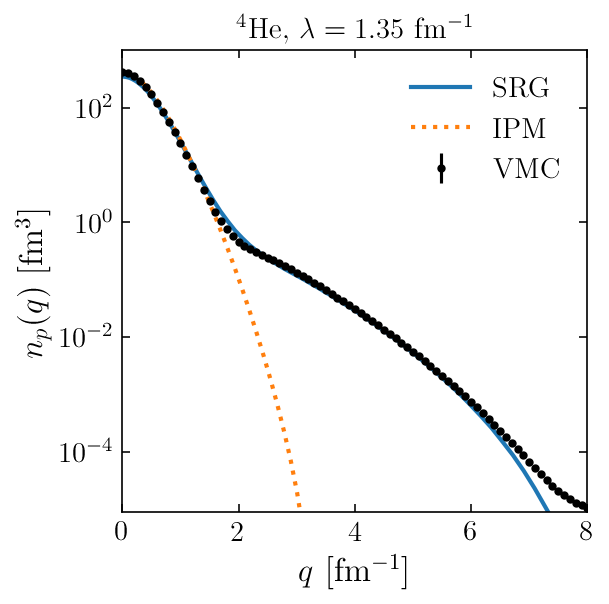

In [11]:
proton_momentum_distribution(nucleus_name, Z, N, kvnn, 1.35, x_limits=(0.0,8.0),
                             print_normalization=True, show_vmc=True, save=True)

SRG normalization = 2.001724218279917.
IPM normalization = 2.0019786275044362.
VMC normalization = 2.000031875649773.


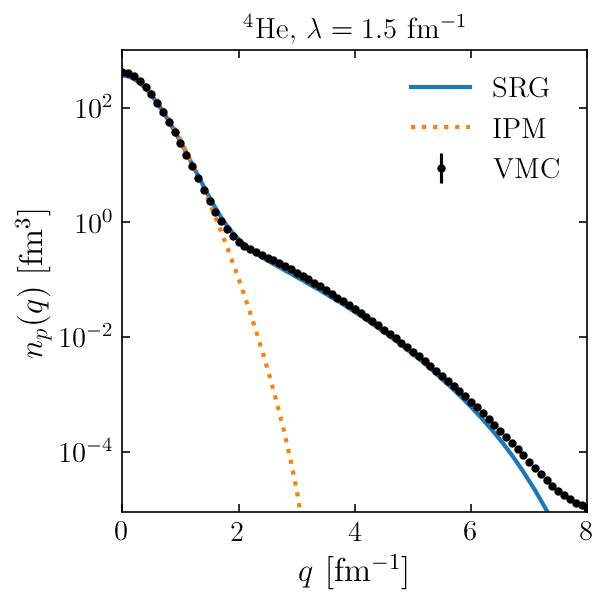

In [12]:
proton_momentum_distribution(nucleus_name, Z, N, kvnn, 1.5, x_limits=(0.0,8.0),
                             print_normalization=True, show_vmc=True, save=True)

SRG normalization = 2.0021733271557722.
IPM normalization = 2.0019786275044362.
VMC normalization = 2.000031875649773.


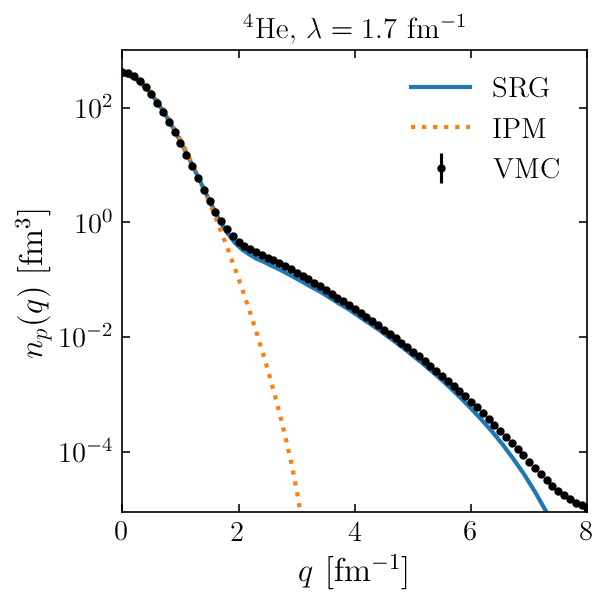

In [13]:
proton_momentum_distribution(nucleus_name, Z, N, kvnn, 1.7, x_limits=(0.0,8.0),
                             print_normalization=True, show_vmc=True, save=True)

SRG normalization = 2.0013303196936962.
IPM normalization = 2.0019786275044362.
VMC normalization = 2.000031875649773.


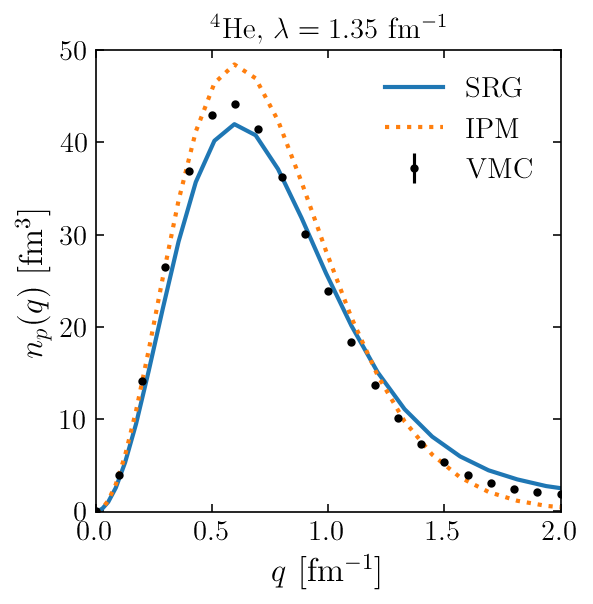

In [14]:
proton_momentum_distribution(
    nucleus_name, Z, N, kvnn, 1.35, print_normalization=True, show_vmc=True,
    y_scale='linear', x_limits=(0.0,2.0), y_limits=(-0.1,50), save=True
)

SRG normalization = 2.001724218279917.
IPM normalization = 2.0019786275044362.
VMC normalization = 2.000031875649773.


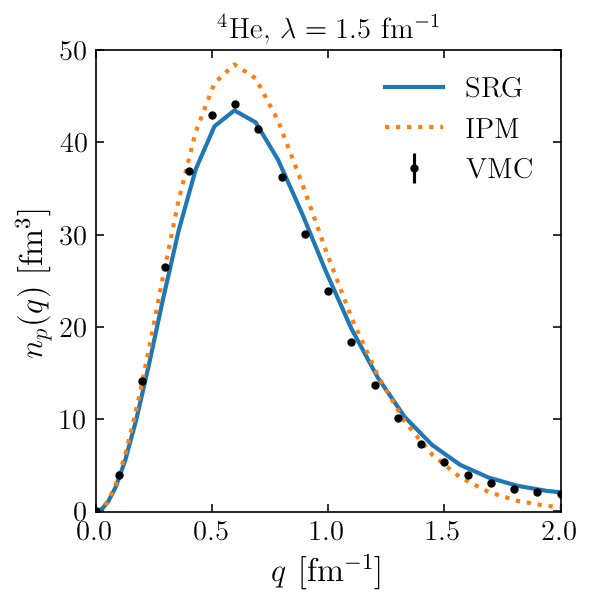

In [15]:
proton_momentum_distribution(
    nucleus_name, Z, N, kvnn, 1.5, print_normalization=True, show_vmc=True,
    y_scale='linear', x_limits=(0.0,2.0), y_limits=(-0.1,50), save=True
)

SRG normalization = 2.0021733271557722.
IPM normalization = 2.0019786275044362.
VMC normalization = 2.000031875649773.


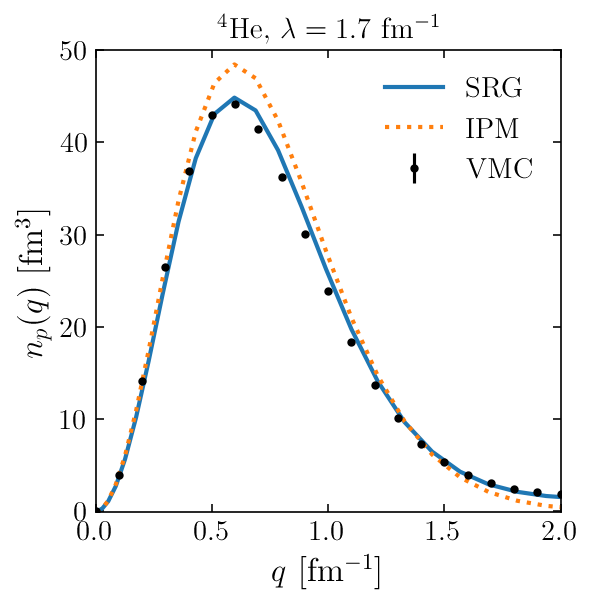

In [16]:
proton_momentum_distribution(
    nucleus_name, Z, N, kvnn, 1.7, print_normalization=True, show_vmc=True,
    y_scale='linear', x_limits=(0.0,2.0), y_limits=(-0.1,50), save=True
)

Total normalization = 2.0013303196936962.
I normalization = 2.0019786275044362.
\delta U + \delta U^\dagger normalization = -0.19886562739063754.
\delta U \delta U^\dagger normalization = 0.19821731957989833.
Relative error = 0.32706920470584294%.


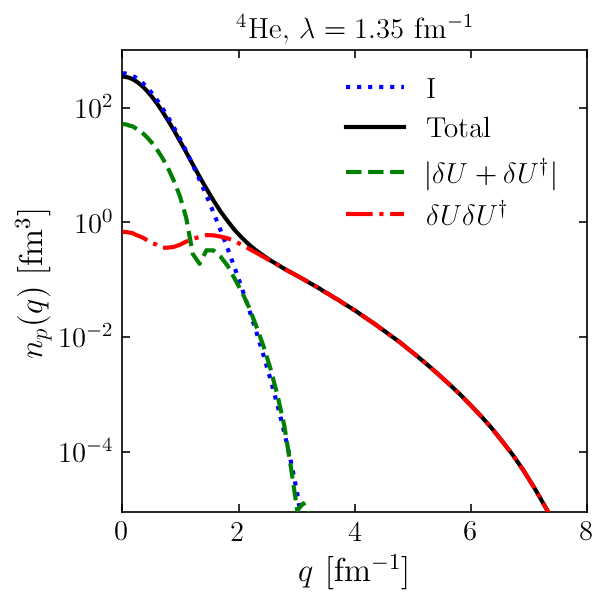

In [17]:
momentum_distribution_contributions(
    nucleus_name, Z, N, kvnn, 1.35, x_limits=(0.0,8.0),
    print_normalization=True, show_vmc=False, save=True
)

Total normalization = 2.0013303196936962.

I normalization = 2.0019786275044362.
\delta U + \delta U^\dagger normalization = -0.19886562739063754.
\delta U \delta U^\dagger normalization = 0.19821731957989833.

LDA \delta U + \delta U^\dagger normalization = -0.20632773420535058.
LDA \delta U \delta U^\dagger normalization = 0.2092953549228127.

\delta U + \delta U^\dagger + \sum \delta U^2 = 0.0006483078107392126.
LDA \delta U + \delta U^\dagger + \sum \delta U^2 = 0.0029676207174621216.


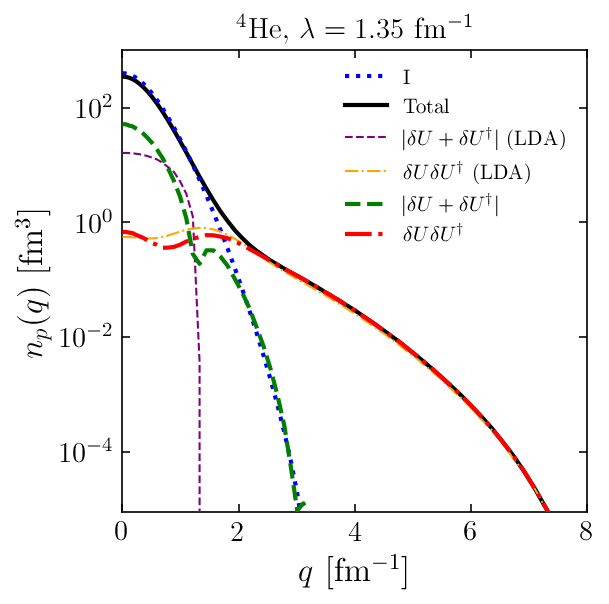

In [18]:
compare_to_lda(
        nucleus_name, Z, N, kvnn, 1.35, x_limits=(0.0,8.0),
        print_normalization=True, save=False
)

### Testing $^{16}$O

In [19]:
nucleus_name, Z, N = 'O16', 8, 8

SRG normalization = 7.995437525324946.
IPM normalization = 7.999071366053643.
VMC normalization = 7.988201791563802.


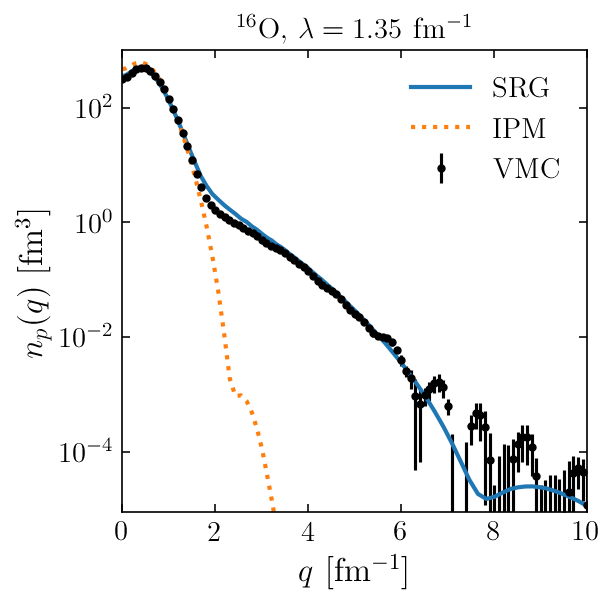

In [20]:
# \lambda = 1.35 fm^-1
proton_momentum_distribution(
    nucleus_name, Z, N, kvnn, 1.35, print_normalization=True, show_vmc=True,
    x_limits=(0.0,10.0), y_limits=(9e-6,1e3), save=True
)

SRG normalization = 7.952424280898321.
IPM normalization = 7.999736764500256.
VMC normalization = 7.988201791563802.


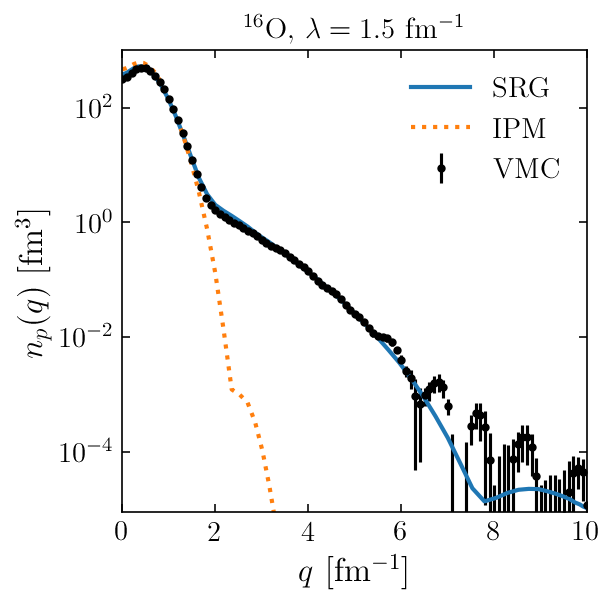

In [21]:
# \lambda = 1.5 fm^-1
proton_momentum_distribution(
    nucleus_name, Z, N, kvnn, 1.5, print_normalization=True, show_vmc=True,
    x_limits=(0.0,10.0), y_limits=(9e-6,1e3), save=True
)

SRG normalization = 7.954615417174087.
IPM normalization = 7.999736764500256.
VMC normalization = 7.988201791563802.


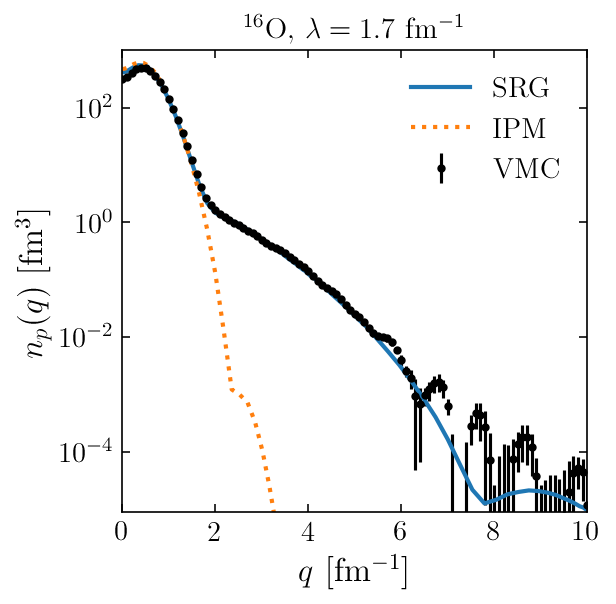

In [22]:
# \lambda = 1.7 fm^-1
proton_momentum_distribution(
    nucleus_name, Z, N, kvnn, 1.7, print_normalization=True, show_vmc=True,
    x_limits=(0.0,10.0), y_limits=(9e-6,1e3), save=True
)

SRG normalization = 7.995437525324946.
IPM normalization = 7.999071366053643.
VMC normalization = 7.988201791563802.


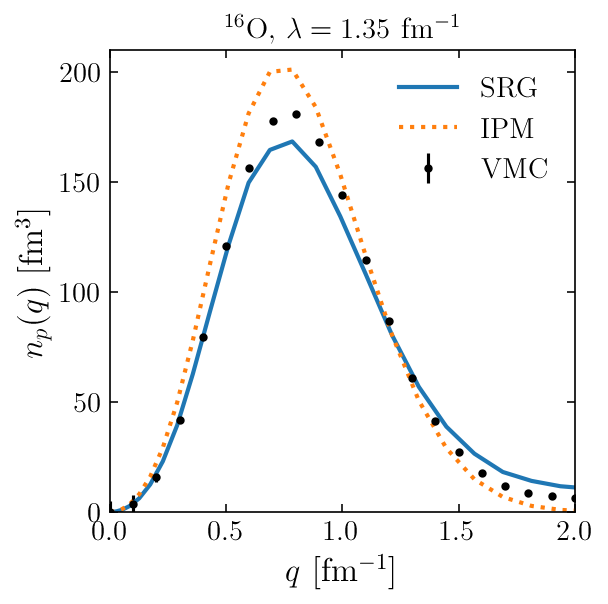

In [23]:
proton_momentum_distribution(
    nucleus_name, Z, N, kvnn, 1.35, print_normalization=True, show_vmc=True,
    y_scale='linear', x_limits=(0.0,2.0), y_limits=(-0.1,210.0), save=True
)

SRG normalization = 7.952424280898321.
IPM normalization = 7.999736764500256.
VMC normalization = 7.988201791563802.


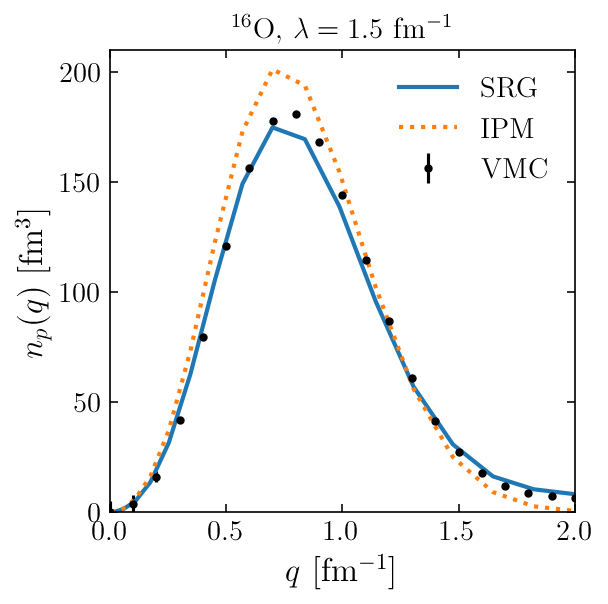

In [24]:
proton_momentum_distribution(
    nucleus_name, Z, N, kvnn, 1.5, print_normalization=True, show_vmc=True,
    y_scale='linear', x_limits=(0.0,2.0), y_limits=(-0.1,210.0), save=True
)

SRG normalization = 7.954615417174087.
IPM normalization = 7.999736764500256.
VMC normalization = 7.988201791563802.


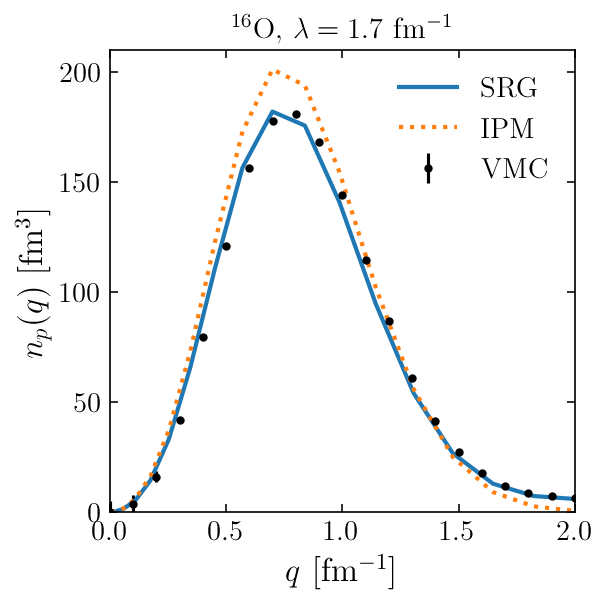

In [25]:
proton_momentum_distribution(
    nucleus_name, Z, N, kvnn, 1.7, print_normalization=True, show_vmc=True,
    y_scale='linear', x_limits=(0.0,2.0), y_limits=(-0.1,210.0), save=True
)

Total normalization = 7.995437525324946.
I normalization = 7.999071366053643.
\delta U + \delta U^\dagger normalization = -1.1280668603190958.
\delta U \delta U^\dagger normalization = 1.1244330195903982.
Relative error = 0.32317093729791574%.


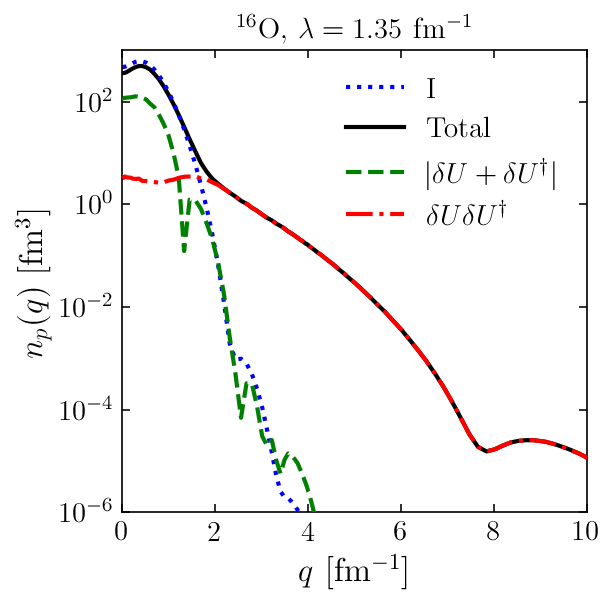

In [26]:
momentum_distribution_contributions(
    nucleus_name, Z, N, kvnn, 1.35, print_normalization=True, show_vmc=False,
    x_limits=(0.0,10.0), y_limits=(1e-6,1e3), save=True
)

Total normalization = 7.995437525324946.

I normalization = 7.999071366053643.
\delta U + \delta U^\dagger normalization = -1.1280668603190958.
\delta U \delta U^\dagger normalization = 1.1244330195903982.

LDA \delta U + \delta U^\dagger normalization = -1.1556678581382578.
LDA \delta U \delta U^\dagger normalization = 1.1471277892377332.

\delta U + \delta U^\dagger + \sum \delta U^2 = 0.003633840728697546.
LDA \delta U + \delta U^\dagger + \sum \delta U^2 = 0.008540068900524611.


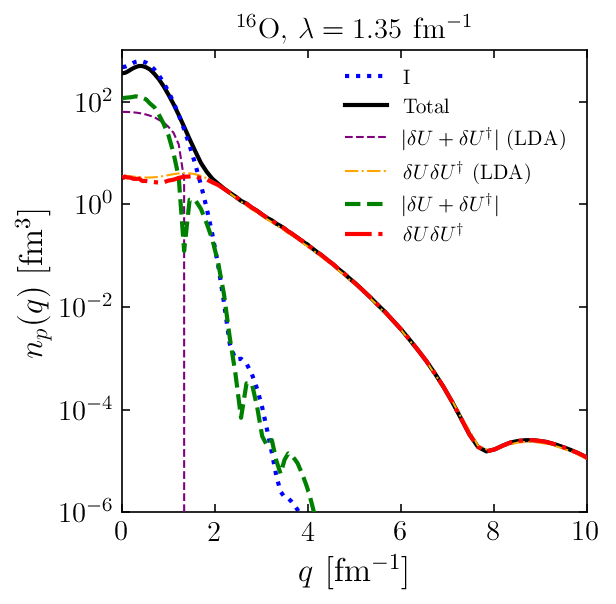

In [27]:
# Compare to LDA on log scale
compare_to_lda(
    nucleus_name, Z, N, kvnn, 1.35, x_limits=(0.0,10.0),
    y_limits=(1e-6,1e3), print_normalization=True, save=False
)